In [16]:
from functools import partial
from pathlib import Path
from typing import Any

import cv2
from cv2 import Mat, UMat
from matplotlib import pyplot as plt   
import numpy as np
from pprint import pprint

from numpy import ndarray, dtype

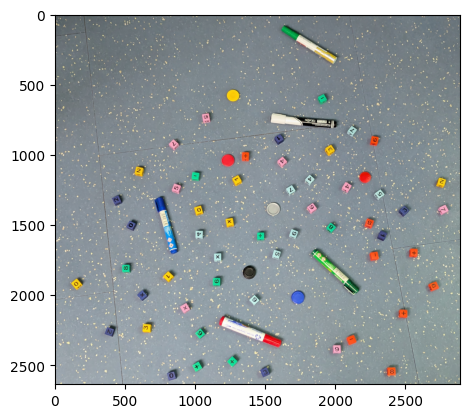

In [17]:
path = Path("img.jpg")
_img = cv2.imread(path)
img_rgb = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)
img_hsv = cv2.cvtColor(_img, cv2.COLOR_BGR2HSV)
plt.imshow(img_rgb)

In [18]:
cols = {
    "white": ((.842, .000, .882), (.153, .126, 1.000)),
    "grey": ((0.078, 0.038, 0.687), (0.211, 0.095, 0.851)),
    "black": ((0.022, 0.000, 0.000), (0.245, 0.605, 0.469)),
    "red": ((0.958, 0.431, 0.370), (0.074, 1.000, 1.000)), # DONE
    "yellow": ((0.107, 0.373, 0.581), (0.201, 1.000, 1.000)), # DONE
    "light_green": ((0.461, 0.123, 0.745), (0.559, 1.000, 1.000)),
    "dark_green": ((0.308, 0.222, 0.000), (0.460, 1.000, 1.000)),
    "pink": ((0.805, 0.190, 0.658), (0.965, 1.000, 1.000)),
    "dark_blue": ((0.601, 0.264, 0.405), (0.662, 1.000, 0.965)),
}
def create_mask(color: str) -> Any:
    color_lower_bound, color_upper_bound = cols[color]
    lower_bound = (np.array(color_lower_bound) * np.array([179, 255, 255])).astype(np.uint8)
    upper_bound = (np.array(color_upper_bound) * np.array([179, 255, 255])).astype(np.uint8)

    # wrap around max value on H channel
    if lower_bound[0] > upper_bound[0]:
        cr_mask = cv2.inRange(img_hsv, lower_bound, np.array((179, upper_bound[1], upper_bound[2]), dtype=np.uint8))
        cr_mask += cv2.inRange(img_hsv, np.array((0, lower_bound[1], lower_bound[2]), dtype=np.uint8), upper_bound)
    else:
        cr_mask = cv2.inRange(img_hsv, lower_bound, upper_bound)

    morph_mask = cr_mask.copy()

    kernels = {
        2: np.ones((2, 2), np.uint8),
        3: np.ones((3, 3), np.uint8),
        5: np.ones((5, 5), np.uint8),
        10: np.ones((10, 10), np.uint8)
    }

    morph_mask = cv2.erode(morph_mask, kernel=kernels[5], iterations=1)
    morph_mask = cv2.dilate(morph_mask, kernel=kernels[5], iterations=1)
    morph_mask = cv2.morphologyEx(morph_mask, op=cv2.MORPH_CLOSE, kernel=kernels[10], iterations=3)
    morph_mask = cv2.morphologyEx(morph_mask, op=cv2.MORPH_OPEN, kernel=kernels[10], iterations=1)
    return morph_mask, cr_mask


color_masks = {}
for col in cols.keys():
    color_masks[col] = create_mask(col)[0]
# region boring
# fig, ax = plt.subplots(1, 2)
# fig.set_size_inches(18.5, 10.5)
# ax[0].imshow(cr_mask)
# ax[1].imshow(morph_mask)
# plt.show()
# endregion

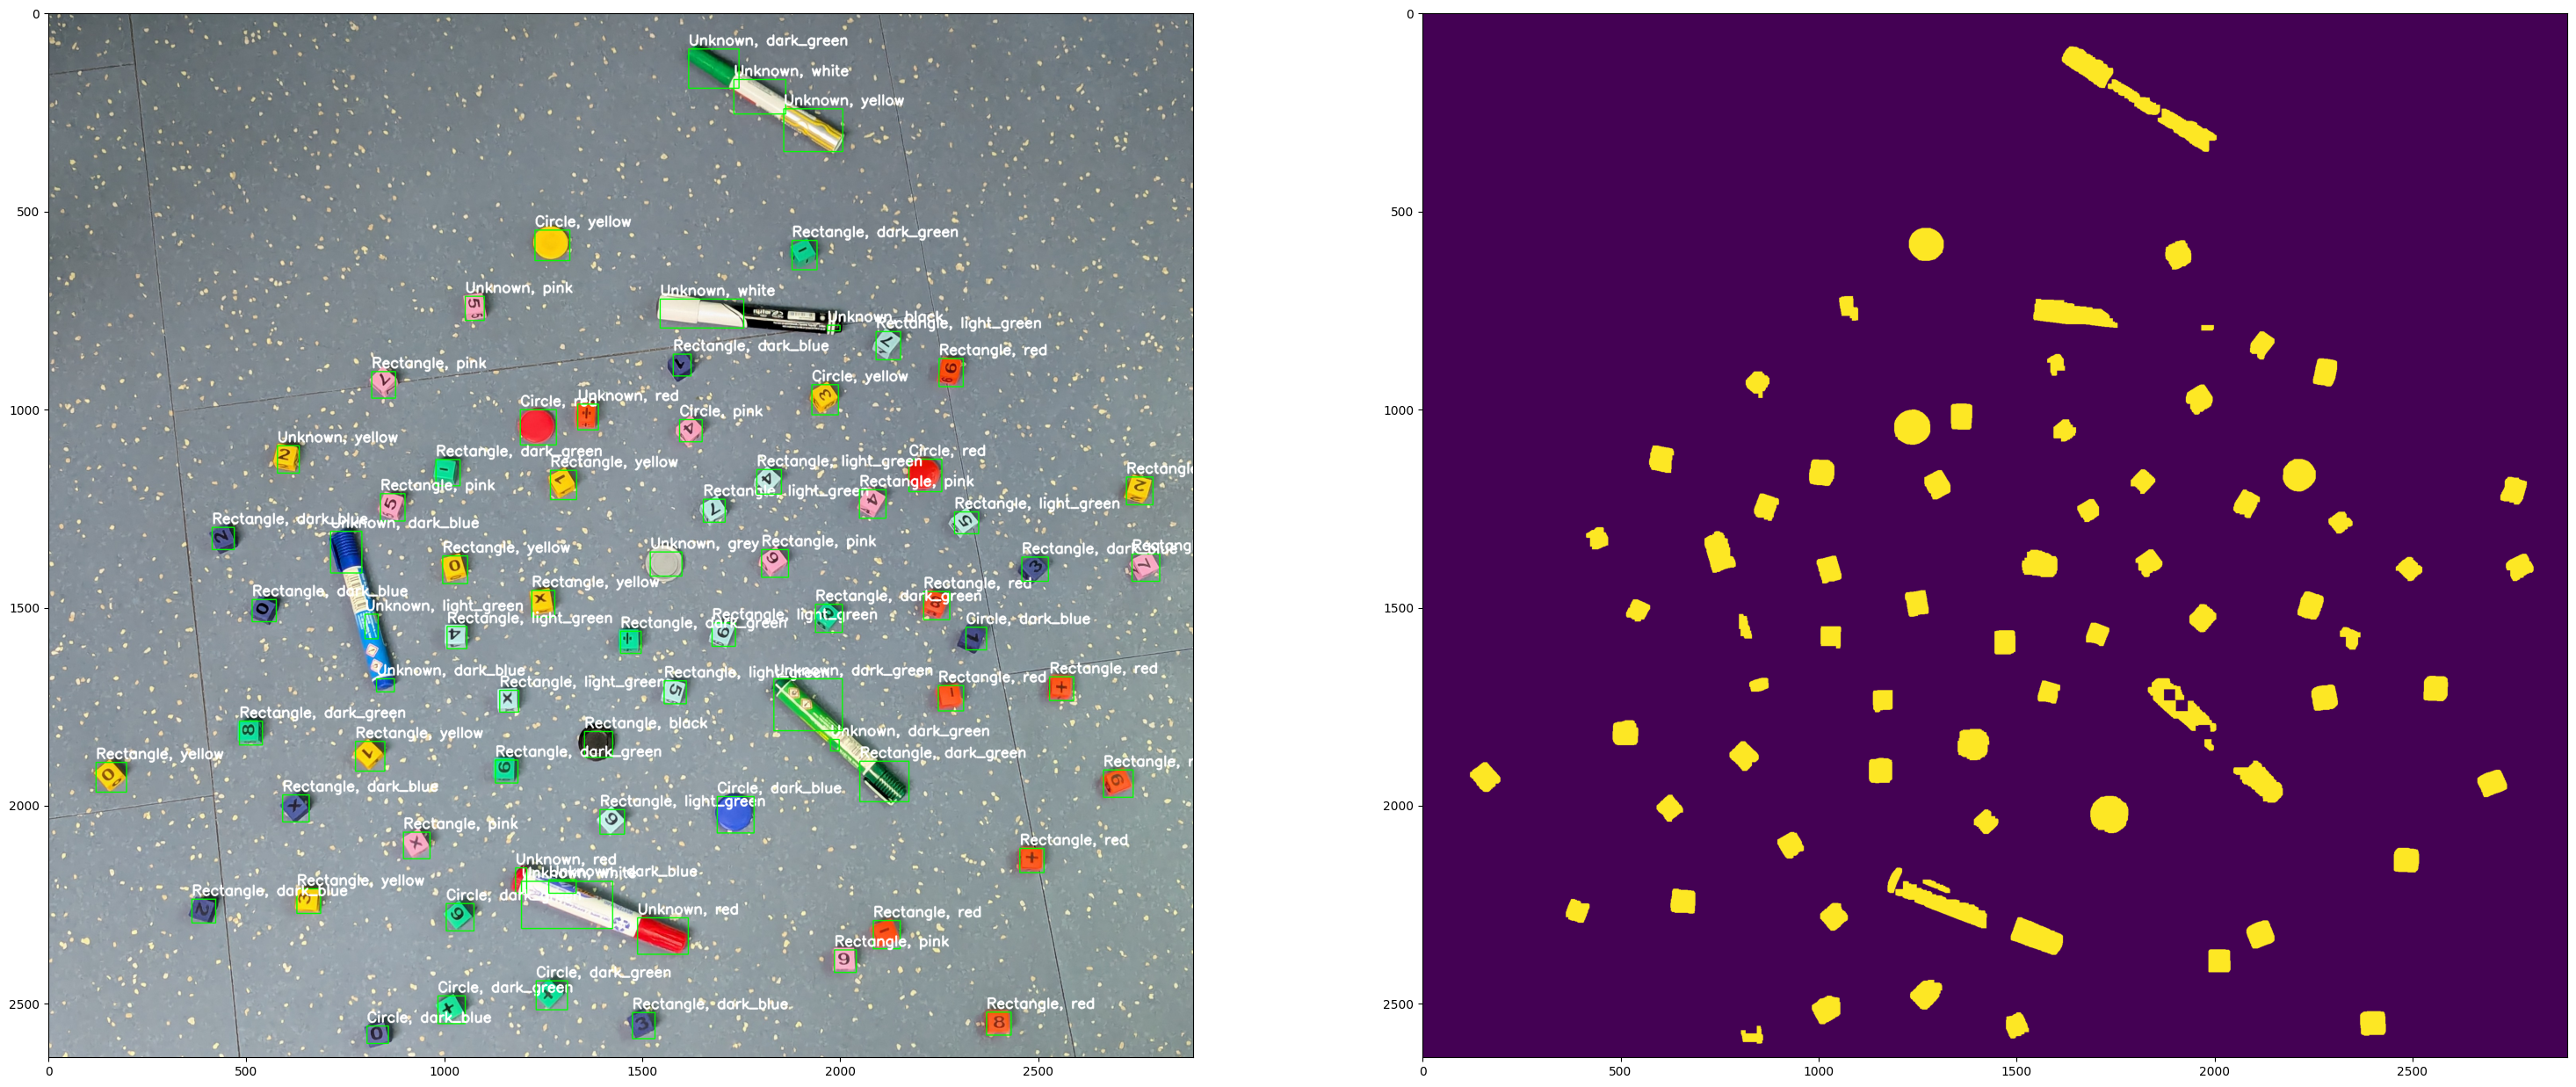

In [20]:
def add_shapes(prepared_mask, image, cur_color):
    contours, _ = cv2.findContours(prepared_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours and identify shapes
    output_image = image.copy()
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)
        x, y, w, h = cv2.boundingRect(approx)


        ratio_thresh = 0.8

        if not ratio_thresh < (w / h) < (1 / ratio_thresh):
            shape_name = "Unknown"
        elif len(approx) == 4:
            shape_name = "Rectangle"
        elif len(approx) > 4:
            shape_name = "Circle"
        else:
            shape_name = "Unknown"

        box_text = f"{shape_name}, {cur_color}"
        # Draw bounding box with text
        cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        cv2.putText(output_image, box_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 3)

    # fig, ax = plt.subplots(1, 2)
    # fig.set_size_inches(18.5, 10.5)
    # ax[0].imshow(output_image)
    # ax[1].imshow(prepared_mask)
    # plt.show()
    return output_image

final_image = add_shapes(color_masks["white"], img_rgb, "white")
for color, morph_mask in color_masks.items():
    if color == "white":
        continue
    final_image = add_shapes(morph_mask, final_image, color)


fig, ax = plt.subplots(1, 2)
fig.set_size_inches(37, 21)
ax[0].imshow(final_image)
ax[1].imshow(sum(color_masks.values()))
plt.show()